In [1]:
import cv2
import cv2.ximgproc as xip
from PIL import Image
import numpy as np
import os
from io import BytesIO
from paddleocr import PaddleOCR
import math

In [26]:
image = cv2.imread("/Users/jiazhengtian/Desktop/1745611090080.jpg")

In [ ]:
class ImageProcessor:
    """
    A class to extract text boxes and relationships from images inside a PPT slide.
    """

    def __init__(self, image):
        """
        Initializes the text box processor.
        
        :param image: Input image to process (as a NumPy array or PIL Image).
        """
        # Convert input image to NumPy array if it's a PIL Image
        if isinstance(image, Image.Image):
            self.image = np.array(image)
        else:
            self.image = image

        # Convert the image to grayscale for processing
        self.gray = cv2.cvtColor(self.image, cv2.COLOR_RGB2GRAY)
        
        # Initialize PaddleOCR for text detection and recognition
        self.ocr = PaddleOCR(use_angle_cls=True, lang="en")

        # Extract initial text boxes, recognized texts, and confidence scores
        self.boxes, self.texts, self.scores = self._extract_text_boxes()

        # Extract combined text boxes and their centers
        self.text_boxes_dict, self.text_boxes_loc = self.get_combined_text_dict()
        self.box_centers = self._calculate_box_centers()
        
        # Find and filter potential text boxes in the image
        self.get_boxes = self.find_boxes()
        self.filtered_boxes = self.filter_boxes(self.get_boxes, self.text_boxes_loc)

        # Detect lines in the image
        self.lines = self.find_lines()

        # Match relationships between text boxes based on detected lines
        self.relationships = self.match_relationships()
    
    def _extract_text_boxes(self):
        """
        Extract text boxes, recognized texts, and confidence scores using PaddleOCR.

        :return: Tuple of (boxes, texts, scores).
        """
        # Run PaddleOCR on the image
        result = self.ocr.ocr(self.image, cls=True)

        if result is None or len(result) == 0 or result[0] is None:
            print("Warning: PaddleOCR detected no text in the image.")
            return [], [], []  # Return empty lists to avoid errors
        
        # Extract bounding boxes, recognized text, and confidence scores
        boxes = [line[0] for line in result[0]]  # Detected text regions
        texts = [line[1][0] for line in result[0]]  # Recognized texts
        scores = [line[1][1] for line in result[0]]  # Confidence scores

        return boxes, texts, scores

    def _boxes_distance(self, box1, box2):
        """
        Compute the Euclidean distance between the centers of two text boxes.

        :param box1: Coordinates of the first text box.
        :param box2: Coordinates of the second text box.
        :return: Euclidean distance between the two box centers.
        """
        # Calculate the center of each box
        center1 = np.mean(box1, axis=0)  # Center of first box
        center2 = np.mean(box2, axis=0)  # Center of second box

        # Compute the Euclidean distance between the centers
        return np.linalg.norm(center1 - center2)

    def get_combined_text_dict(self):
        """
        Merge nearby text boxes and concatenate their corresponding texts if the distance between them is smaller than a specified threshold.

        :return: 
            - combined_dict: A dictionary {tuple(box_coordinates): merged_text}
                             where each key is a 4-point bounding box ((x1, y1), ..., (x4, y4)),
                             and the value is the merged text string.
            - text_boxes_loc: A list of simplified axis-aligned bounding boxes [(x1, y1, x4, y4)] as [(x1, y1, x2, y2)]
                              representing the merged regions.
        """
        distance_threshold = 40  # Maximum distance between two text boxes to be merged
        combined_dict = {}  # Store box coordinates and text mapping
        used = [False] * len(self.boxes)  # Track which boxes have already been merged

        for i in range(len(self.boxes)):
            if used[i]:
                continue  # Skip already merged boxes

            # Initialize current box and text
            current_box = np.array(self.boxes[i], dtype=np.int32)
            current_text = [self.texts[i]]  # Store text as a list to append later
            used[i] = True  # Mark as merged

            for j in range(i + 1, len(self.boxes)):
                if used[j]:
                    continue  # Skip already-used boxes

                # Compute the distance between boxes
                distance = self._boxes_distance(current_box, self.boxes[j])

                # Merge if within threshold
                if distance < distance_threshold:
                    # Combine box coordinates
                    combined_points = np.vstack((current_box, self.boxes[j]))
                    combined_points = np.array(combined_points, dtype=np.int64)

                    # Ensure valid bounding box
                    if len(combined_points) >= 2:
                        try:
                            rect = cv2.minAreaRect(combined_points)
                            current_box = cv2.boxPoints(rect)  # Get the updated box

                            # Merge text
                            current_text.append(self.texts[j])  # Append the text
                            used[j] = True
                        except Exception as e:
                            print(f"Error in cv2.minAreaRect: {e}")
                            continue

            # Convert NumPy array to a tuple (so it can be used as a dictionary key)
            box_tuple = tuple(map(tuple, current_box))  # Convert to ((x1, y1), (x2, y2), ...)
            combined_dict[box_tuple] = " ".join(current_text)  # Store as key-value pair

        # Initialize list to store simplified bounding boxes
        text_boxes_loc = []

        # Convert each 4-point rotated box into an axis-aligned bounding box
        for box_coords in combined_dict.keys():
            coords = list(box_coords)  # Convert tuple to list of points

            # Separate x and y coordinates
            x_coords = [p[0] for p in coords]
            y_coords = [p[1] for p in coords]

            # Calculate axis-aligned bounding box: (min_x, min_y, max_x, max_y)
            bbox = (
                min(x_coords),  # Left boundary
                min(y_coords),  # Top boundary
                max(x_coords),  # Right boundary
                max(y_coords)   # Bottom boundary
            )

            # Add to the result list
            text_boxes_loc.append(bbox)

        return combined_dict, text_boxes_loc
    
    def find_boxes(self):
        """
        Detects bounding boxes of potential text areas in the image.

        :return: A list of bounding boxes in the format [(x1, y1, x2, y2), ...]
        """

        # Convert to binary threshold (inverse)
        _, binary = cv2.threshold(self.gray, 128, 255, cv2.THRESH_BINARY_INV)

        # Find contours in the binary image
        contours, _ = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

        # Apply morphological operations to clean noise
        kernel = np.ones((3, 3), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)  # Remove noise
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)  # Fill gaps

        # Detect bounding boxes
        get_boxes = []
        margin_threshold = 10
        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)
            if w * h > 1000:  # Filter out small regions
                get_boxes.append((x, y, x + w, y + h))
        
        # Filter out boxes that are too close to each other
        filtered_boxes = []
        image_height, image_width = self.image.shape[:2]
        max_area_threshold = image_height * image_width * 0.8
        for box in get_boxes:
            x1, y1, x2, y2 = box
            area = (x2 - x1) * (y2 - y1)
            if area > max_area_threshold:
                continue  # Skip boxes that are too large
            filtered_boxes.append(box)
        get_boxes = filtered_boxes

        return get_boxes

    def iou(self, box1, box2):
        """
        Computes the Intersection over Union (IoU) between two bounding boxes.

        :param box1: First bounding box (x1, y1, x2, y2)
        :param box2: Second bounding box (x1, y1, x2, y2)
        :return: IoU score (value between 0 and 1)
        """
        # Compute intersection coordinates
        x1, y1, x2, y2 = box1
        x1_, y1_, x2_, y2_ = box2

        inter_x1 = max(x1, x1_)
        inter_y1 = max(y1, y1_)
        inter_x2 = min(x2, x2_)
        inter_y2 = min(y2, y2_)

        # Compute intersection area
        inter_area = max(0, inter_x2 - inter_x1) * max(0, inter_y2 - inter_y1)
        box1_area = (x2 - x1) * (y2 - y1)
        box2_area = (x2_ - x1_) * (y2_ - y1_)

        # Compute IoU
        return inter_area / float(box1_area + box2_area - inter_area)

    def filter_boxes(self, get_boxes, text_boxes_loc):
        """
        Filters out overlapping bounding boxes. This is used to retain the smallest bounding regions.
        If no drawn (plotted) boxes are found, fallback to text box regions.

        :param get_boxes: List of candidate bounding boxes (e.g., from line/edge detection).
        :param 
        
        
        : Backup list of text-detected bounding boxes (AABB format).
        :return: Filtered list of bounding boxes, excluding large overlaps or (0,0,...) dummies.
        """
        filtered_boxes = []

        usable_boxes = get_boxes if len(get_boxes) > 0 else text_boxes_loc  # Use text boxes if no plotted boxes are found

        for i, box1 in enumerate(usable_boxes):
            keep = True
            for j, box2 in enumerate(usable_boxes):
                if i != j and self.iou(box1, box2) > 0.4:  # Overlapping threshold
                    if (box1[2] - box1[0]) * (box1[3] - box1[1]) > (box2[2] - box2[0]) * (box2[3] - box2[1]):
                        keep = False  # Remove the larger box if overlap is high
            if keep:
                filtered_boxes.append(box1)

        return [box for box in filtered_boxes if not (box[0] == 0 and box[1] == 0)]

    def apply_mask(self):
        """
        Applies a mask to remove detected text areas from the image.
        
        :return: Masked grayscale image and its edge-detected version.
        """
        # Create a mask to hide text regions
        mask = np.ones_like(self.gray) * 255
        for box in self.filtered_boxes:
            x1, y1, x2, y2 = map(int, box)
            mask[y1:y2, x1:x2] = 0  # Mask out text areas

        # Apply the mask to the grayscale image
        masked_gray = cv2.bitwise_and(self.gray, self.gray, mask=mask)
        # Detect edges in the masked image
        mask_edges = cv2.Canny(mask, 100, 200)

        return masked_gray, mask_edges

    @staticmethod
    def is_point_near_edge(x, y, mask_edges, neighborhood_size=5):
        """
        Checks if a point (x, y) is near an edge in the masked image.

        :param x: X-coordinate of the point.
        :param y: Y-coordinate of the point.
        :param mask_edges: Edge-detected version of the masked image.
        :param neighborhood_size: Search window size.
        :return: Boolean indicating whether the point is near an edge.
        """
        # Define the search window around the point
        x_min = max(0, x - neighborhood_size // 2)
        x_max = min(mask_edges.shape[1] - 1, x + neighborhood_size // 2)
        y_min = max(0, y - neighborhood_size // 2)
        y_max = min(mask_edges.shape[0] - 1, y + neighborhood_size // 2)

        # Check if any edge pixel exists in the neighborhood
        return np.any(mask_edges[y_min:y_max + 1, x_min:x_max + 1] == 255)

    @staticmethod
    def distance_between_points(p1, p2):
        return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)
    
    @staticmethod
    def normalize_line(line):
        x0, y0, x1, y1 = line
        return (x0, y0, x1, y1) if x0 < x1 else (x1, y1, x0, y0)
    
    @staticmethod
    def angle_between_lines(line1, line2):
        """
        Computes the angle between two lines.

        :param line1: First line segment (x1, y1, x2, y2)
        :param line2: Second line segment (x1, y1, x2, y2)
        :return: Angle in degrees.
        """
        def line_angle(line):
            dx, dy = line[2] - line[0], line[3] - line[1]
            return np.degrees(np.arctan2(dy, dx))

        angle1 = line_angle(line1)
        angle2 = line_angle(line2)

        # Compute the angle using the dot product
        angle_diff = abs(line_angle(line1) - line_angle(line2))
        angle_diff = min(angle_diff, 360 - angle_diff)
        return angle_diff

    @staticmethod
    def are_lines_similar(line1, line2, length_threshold=5, midpoint_threshold=5, angle_threshold=5):
        """
        Determines whether two lines are similar based on length, midpoint, and angle.

        :param line1: First line segment (x1, y1, x2, y2)
        :param line2: Second line segment (x1, y1, x2, y2)
        :return: Boolean indicating similarity.
        """


        # Normalize lines to ensure consistent start and end points
        line1, line2 = ImageProcessor.normalize_line(line1), ImageProcessor.normalize_line(line2)

        def line_length(line):
            return np.linalg.norm([line[2] - line[0], line[3] - line[1]])

        def line_midpoint(line):
            return ((line[0] + line[2]) / 2, (line[1] + line[3]) / 2)

        def line_angle(line):
            dx, dy = line[2] - line[0], line[3] - line[1]
            return np.degrees(np.arctan2(dy, dx))

        # Compute differences in length, midpoint, and angle
        length_diff = abs(line_length(line1) - line_length(line2))
        midpoint_dist = np.linalg.norm(np.array(line_midpoint(line1)) - np.array(line_midpoint(line2)))
        # angle_diff = abs(line_angle(line1) - line_angle(line2))
        angle_diff = ImageProcessor.angle_between_lines(line1, line2)  # Handle circular angle differences

        # Check if lines are similar based on thresholds
        return (length_diff < length_threshold and midpoint_dist < midpoint_threshold and angle_diff < angle_threshold)


    def _merge_similar_nearby_lines(self, lines, point_threshold=5, angle_threshold=5):
        """
        Merges similar lines whose endpoints are close.

        :param lines: List of lines in the format [(x1, y1, x2, y2), ...].
        :param point_threshold: Maximum distance between endpoints to consider merging.
        :return: List of merged lines.
        """
        merged = True
        merged_lines = list(lines)  # Start with a copy
        # Normalize lines to ensure consistent start and end points
        merged_lines = [self.normalize_line(line) for line in merged_lines]

        while merged:
            merged = False
            new_merged_lines = []
            used = [False] * len(merged_lines)

            for i in range(len(merged_lines)):
                if used[i]:
                    continue
                line1 = merged_lines[i]
                used[i] = True
                merged_segment = list(line1)

                for j in range(i + 1, len(merged_lines)):
                    if not used[j]:
                        line2 = merged_lines[j]

                        p1 = (line1[0], line1[1])
                        p2 = (line1[2], line1[3])
                        q1 = (line2[0], line2[1])
                        q2 = (line2[2], line2[3])

                        endpoints1 = [p1, p2]
                        endpoints2 = [q1, q2]

                        # Check if lines are similar AND nearby
                        if self.angle_between_lines(line1, line2) < angle_threshold and \
                            any(self.distance_between_points(end1, end2) < point_threshold
                               for end1 in endpoints1 for end2 in endpoints2):

                            # Merge the lines by finding the overall bounding box
                            all_points = endpoints1 + endpoints2
                            min_x = min(p[0] for p in all_points)
                            min_y = min(p[1] for p in all_points)
                            max_x = max(p[0] for p in all_points)
                            max_y = max(p[1] for p in all_points)
                            merged_segment = [min_x, min_y, max_x, max_y]
                            used[j] = True
                            merged = True

                new_merged_lines.append(tuple(merged_segment))

            merged_lines = [list(line) for line in new_merged_lines]

        return merged_lines

    def find_lines(self):
        """
        Detects unique line segments in the image, filtering out redundant lines.

        :return: List of detected lines in the format [(x1, y1, x2, y2), ...]
        """
        # Apply mask to remove text regions and detect edges
        masked_gray, mask_edges = self.apply_mask()

        # Detect lines using Line Segment Detector
        lsd = cv2.createLineSegmentDetector(0)
        dlines = lsd.detect(masked_gray)

        unique_lines = []

        # Ensure that dlines is not None before processing
        if dlines is None or dlines[0] is None:
            print("Warning: No lines detected in the image.")
            return []  # Return an empty list instead of None to prevent errors

        lines = [dline[0] for dline in dlines[0]]
        merged_lines = self._merge_similar_nearby_lines(lines)

        unique_merged_lines = []

        for line in merged_lines:
            # line = self.normalize_line(line)  # Normalize line coordinates
            # Check if the line is already in the unique list
            if line in unique_merged_lines:
                continue
            x0, y0, x1, y1 = map(int, line)

            # Ignore lines near text regions
            if self.is_point_near_edge(x0, y0, mask_edges) and self.is_point_near_edge(x1, y1, mask_edges):
                continue  # Ignore lines near text regions

            # Filter out short lines
            if np.linalg.norm([x1 - x0, y1 - y0]) > 10:  # Minimum line length
                current_line = (x0, y0, x1, y1)

                # Check if the line is similar to any existing line
                if not any(self.are_lines_similar(current_line, unique_line) for unique_line in unique_merged_lines):
                    unique_merged_lines.append(current_line)

        return unique_merged_lines
    
    def _calculate_box_centers(self):
        """
        Computes the center points for all text boxes.

        :return: Dictionary {(cx, cy): text}
                 - Key: Center coordinates (cx, cy)
                 - Value: Corresponding text inside the bounding box
        """
        centers_dict = {}
        for box, text in self.text_boxes_dict.items():
            # Compute the center of the bounding box
            cx = np.mean([p[0] for p in box])  # Average x-coordinates
            cy = np.mean([p[1] for p in box])  # Average y-coordinates
            centers_dict[(cx, cy)] = text  # Store as dictionary {center: text}
        return centers_dict

    def _find_nearest_textbox(self, x, y):
        """
        Finds the nearest text box center for a given point (x, y).

        :param x: X-coordinate of the point
        :param y: Y-coordinate of the point
        :return: The text of the nearest box and its center (cx, cy),
                 or None if no match is found
        """
        min_distance = float("inf")
        nearest_text = None
        nearest_center = None  # Store the nearest box center

        for (cx, cy), text in self.box_centers.items():
            distance = np.sqrt((cx - x) ** 2 + (cy - y) ** 2)
            if distance < min_distance:
                min_distance = distance
                nearest_text = text
                nearest_center = (cx, cy)  # Save the nearest center

        return nearest_text, nearest_center

    def match_relationships(self):
        """
        Matches text boxes based on line segment connections (from-bottom-to-top)
        and removes duplicates while ensuring correct ordering.

        :return: List of unique (from_text, to_text) relationships sorted bottom-to-top, left-to-right.
        """
        relationships = set()  # Use a set to remove duplicates

        for line in self.lines:
            x0, y0, x1, y1 = line  # Extract line segment endpoints

            # Find the nearest text box for both endpoints
            text_from, center_from = self._find_nearest_textbox(x0, y0)
            text_to, center_to = self._find_nearest_textbox(x1, y1)

            # Ensure valid matches and maintain "bottom-to-top" relationship
            if text_from and text_to and (text_from != text_to):
                if y0 > y1:  # Ensure "from" is at the bottom
                    relationships.add((text_from, text_to, center_from, center_to))
                else:  # Swap if necessary
                    relationships.add((text_to, text_from, center_to, center_from))

        # **Sorting rules**
        # 1. Sort primarily by `from_center[1]` in descending order (bottom-to-top)
        # 2. If `y` coordinates are the same, sort by `from_center[0]` in ascending order (left-to-right)
        sorted_relationships = sorted(
            relationships, key=lambda item: (-item[2][1], item[2][0])
        )

        # Convert to list of edges
        edges = [(from_text, to_text) for from_text, to_text, _, _ in sorted_relationships]

        # Return the final relationship list
        return edges

In [27]:
ip = ImageProcessor(image)

[2025/04/25 16:41:44] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/Users/jiazhengtian/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/Users/jiazhengtian/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320',

In [5]:
boxes = ip.find_boxes()

In [6]:
boxes

[]

In [7]:
import matplotlib.pyplot as plt

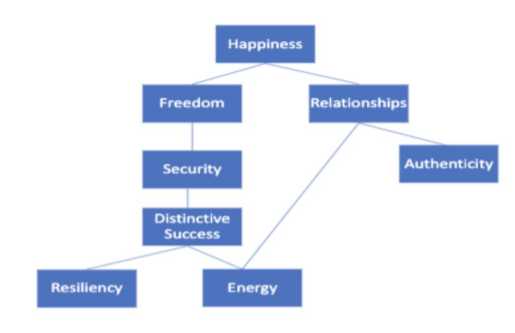

In [8]:
for box in boxes:
    x1, y1, x2, y2 = box
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw bounding boxes
    cv2.putText(image, "text", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    # Display the image with bounding boxes
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [9]:
lines = ip.find_lines()

In [10]:
lines.sort(key=lambda line: (line[0], line[1]))  # Sort lines by y-coordinate
lines

[(53, 519, 53, 594),
 (54, 594, 253, 594),
 (55, 526, 340, 495),
 (169, 494, 461, 462),
 (252, 519, 252, 594),
 (264, 153, 500, 135),
 (264, 224, 264, 148),
 (264, 224, 463, 224),
 (264, 280, 463, 280),
 (264, 355, 264, 280),
 (264, 395, 264, 470),
 (265, 356, 463, 356),
 (265, 395, 464, 395),
 (352, 359, 356, 391),
 (361, 228, 366, 278),
 (361, 473, 452, 515),
 (379, 108, 681, 116),
 (384, 516, 384, 591),
 (385, 517, 583, 517),
 (385, 592, 584, 592),
 (410, 29, 410, 104),
 (410, 29, 608, 29),
 (462, 468, 463, 394),
 (463, 224, 463, 149),
 (463, 227, 696, 515),
 (463, 280, 463, 355),
 (523, 128, 796, 155),
 (583, 593, 583, 516),
 (597, 224, 598, 149),
 (598, 218, 854, 241),
 (609, 105, 609, 30),
 (710, 251, 975, 276),
 (777, 270, 778, 344),
 (778, 345, 975, 345),
 (795, 149, 795, 224),
 (975, 344, 975, 269)]

In [11]:
len(lines)

36

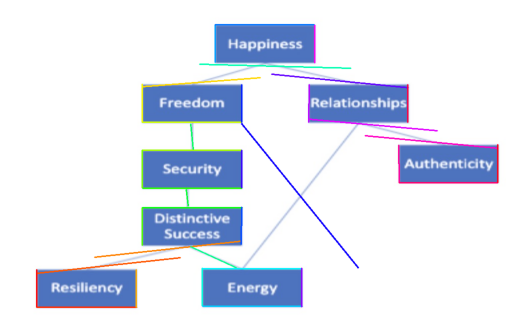

In [12]:
colors = plt.cm.get_cmap('hsv', len(lines))  # Generate a colormap for unique colors
for i, line in enumerate(lines):
    x0, y0, x1, y1 = line
    color = colors(i)[:3]
    color_bgr = tuple(int(c * 255) for c in reversed(color)) 
    cv2.line(image, (x0, y0), (x1, y1), color_bgr, 2)  # plot lines with unique colors

# Display the image with lines
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [38]:
relations = ip.match_relationships()

In [39]:
relations

[('Energy', 'Distinctive Success'),
 ('Energy', 'Freedom'),
 ('Resiliency', 'Energy'),
 ('Resiliency', 'Distinctive Success'),
 ('Distinctive Success', 'Security'),
 ('Security', 'Freedom'),
 ('Authenticity', 'Relationships'),
 ('Relationships', 'Happiness'),
 ('Relationships', 'Freedom'),
 ('Freedom', 'Happiness')]

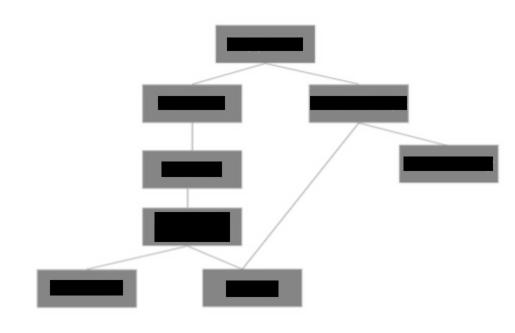

In [28]:
masked_gray, _ = ip.apply_mask()
plt.imshow(masked_gray, cmap='gray')
plt.axis('off')
plt.show()

In [24]:
ip.ocr.ocr(image, cls=True)

[2025/04/25 16:28:11] ppocr DEBUG: dt_boxes num : 9, elapsed : 0.7324578762054443
[2025/04/25 16:28:12] ppocr DEBUG: cls num  : 9, elapsed : 0.15862083435058594
[2025/04/25 16:28:13] ppocr DEBUG: rec_res num  : 9, elapsed : 1.0880260467529297


[[[[[434.0, 55.0], [586.0, 58.0], [586.0, 82.0], [434.0, 80.0]],
   ('Happiness', 0.9980136156082153)],
  [[[298.0, 174.0], [429.0, 176.0], [429.0, 199.0], [297.0, 197.0]],
   ('Freedom', 0.9980484247207642)],
  [[[602.0, 172.0], [791.0, 175.0], [790.0, 200.0], [601.0, 197.0]],
   ('Relationships', 0.997604250907898)],
  [[[789.0, 293.0], [965.0, 297.0], [965.0, 322.0], [788.0, 319.0]],
   ('Authenticity', 0.9648528695106506)],
  [[[305.0, 303.0], [424.0, 308.0], [423.0, 334.0], [303.0, 329.0]],
   ('Security', 0.997718334197998)],
  [[[289.0, 403.0], [441.0, 406.0], [441.0, 430.0], [288.0, 428.0]],
   ('Distinctive', 0.9973899722099304)],
  [[[308.0, 436.0], [421.0, 439.0], [420.0, 460.0], [308.0, 458.0]],
   ('Success', 0.9967831373214722)],
  [[[81.0, 540.0], [226.0, 545.0], [225.0, 571.0], [80.0, 566.0]],
   ('Resiliency', 0.981592059135437)],
  [[[434.0, 541.0], [536.0, 548.0], [534.0, 574.0], [432.0, 567.0]],
   ('Energy', 0.9987278580665588)]]]

In [29]:
lsd = cv2.createLineSegmentDetector(0)
dlines = lsd.detect(masked_gray)

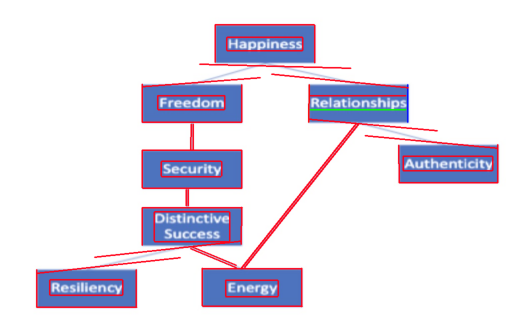

In [30]:
colors = plt.cm.get_cmap('hsv', len(dlines))  # Generate a colormap for unique colors
lines = dlines[0]
for i, line in enumerate(lines):
    x0, y0, x1, y1 = map(int, line[0])
    color = colors(i)[:3]
    color_bgr = tuple(int(c * 255) for c in reversed(color)) 
    cv2.line(image, (x0, y0), (x1, y1), color_bgr, 2)  # plot lines with unique colors

# Display the image with lines
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()